# Problem 1 - Variational Auto-Encoder (VAE)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jesbu1/csci-566-assignment2/blob/master/CSCI566_Assignment2_problem_1_VAE.ipynb)


Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks (GANs, see Problem 2), they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e. learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

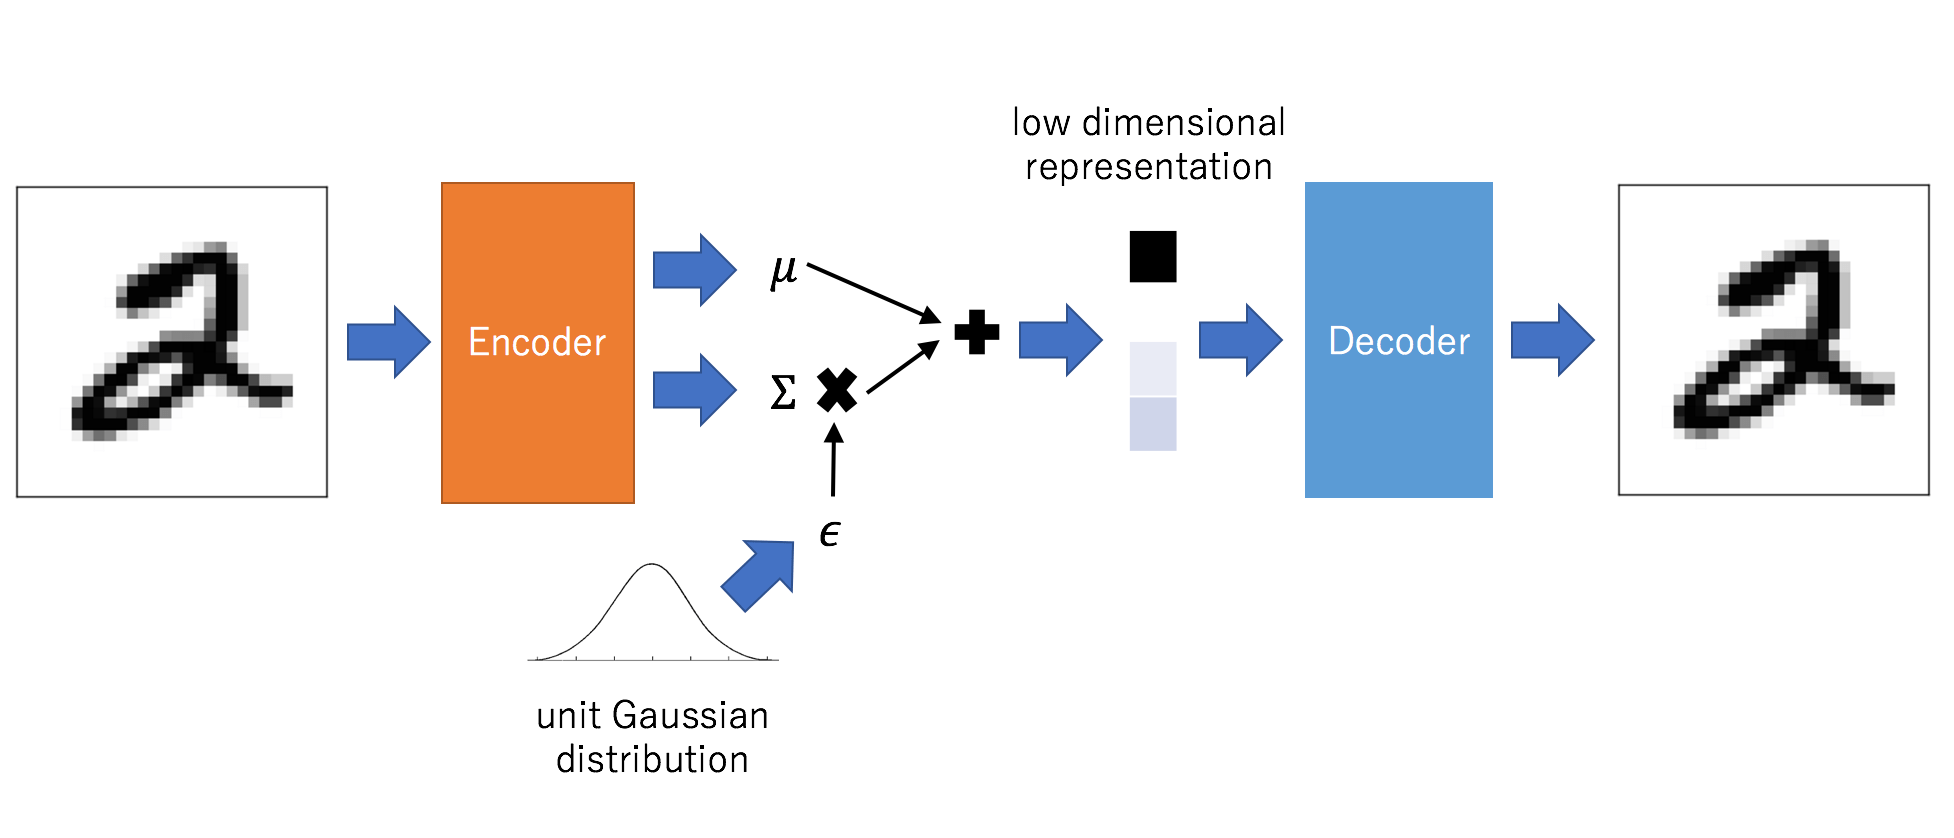
*(image source: https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1)*

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.


**Note**: For faster training of the models in this assignment you can use Colab with enabled GPU support. In Colab, navigate to "Runtime" --> "Change Runtime Type" and set the "Hardware Accelerator" to "GPU". 

# 1. MNIST Dataset

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.

Another benefit is that it is so widely used that PyTorch even provides functionality to automatically download it.

Let's start by downloading the data and visualizing some samples.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torchvision

# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(root='./data', 
                                         train=True, 
                                         download=True, 
                                         transform=torchvision.transforms.ToTensor())
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!

 Download complete! Downloaded 60000 training examples!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


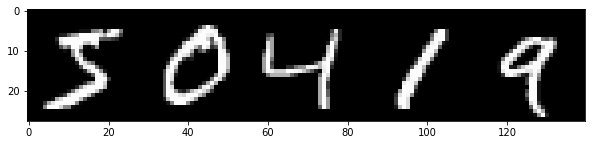

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Let's display some of the training samples.
sample_images = []
mnist_it = iter(mnist_train)  # create simple iterator, later we will use proper DataLoader
for _ in range(5):
  sample = next(mnist_it)     # samples a tuple (image, label)
  sample_images.append(sample[0][0].data.cpu().numpy())

fig = plt.figure(figsize = (10, 50))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()


# 2. Auto-Encoder

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders feature the same encoder-decoder architecture as VAEs and therefore also learn a low-dimensional representation of the input data without supervision. In contrast to VAEs they are **fully deterministic** models and do not employ variational inference for optimization.

The **architecture** is very simple: we will encode the input image into a low-dimensional representation using a convolutional network with strided convolutions that reduce the image resolution in every layer. This results in a low-dimensional representation of the input image. This representation will get decoded back into the dimensionality of the input image using a convolutional decoder network that mirrors the architecture of the encoder. It employs transposed convolutions to increase the resolution of its input in every layer. The whole model is trained by **minimizing a reconstruction loss** between the input and the decoded image.

Intuitively, the **auto-encoder needs to compress the information contained in the input image** into a much lower dimensional representation (e.g. 28x28=784px vs. 64 embedding dimensions for our MNIST model). This is possible since the information captured in the pixels is *highly redundant*. E.g. encoding an MNIST image requires <4 bits to encode which of the 10 possible digits is displayed and a few additional bits to capture information about shape and orientation. This is much less than the $255^{28\cdot 28}$ bits of information that could be theoretically captured in the input image.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture [6pt]

In [6]:
import torch.nn as nn

# Let's define encoder and decoder networks
#####################################################################
# Encoder Architecture:                                             #
#   - Conv2d, hidden units: 32, output resolution: 14x14, kernel: 4 #
#   - LeakyReLU                                                     #
#   - Conv2d, hidden units: 64, output resolution: 7x7, kernel: 4   #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - Conv2d, hidden units: 128, output resolution: 3x3, kernel: 3  #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - Conv2d, hidden units: 256, output resolution: 1x1, kernel: 3  #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - Flatten                                                       #
#   - Linear, output units: nz (= representation dimensionality)    #
#####################################################################

class Encoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # All convolutional layers should also learn a bias.                           #
    # HINT: use the given information to compute stride and padding                #
    #       for each convolutional layer. Verify the shapes of intermediate layers #
    #       by running partial networks (with the next cell) and visualizing the   #
    #       output shapes.                                                         #
    ################################################################################
    self.net = nn.Sequential(
        # add your network layers here
        # ...
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 4, stride = 2, padding = 1, bias = True),     # The 1*28*28 to 32*14*14 with kernel of 4*4, the padding is 1 and the strike is 2
        nn.LeakyReLU(),
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias = True), 
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2, padding = 0, bias = True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels= 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 0, bias = True),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Flatten(),
        nn.Linear(256,nz)
    )
    ################################ END TODO #######################################
  
  def forward(self, x):
    return self.net(x)


#####################################################################
# Decoder Architecture (mirrors encoder architecture):              #
#   - Linear, output units: 256                                     #
#   - Reshape, output shape: (256, 1, 1)                            #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - ConvT2d, hidden units: 128, output resolution: 3x3, kernel: 3 #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - ConvT2d, hidden units: 64, output resolution: 7x7, kernel: 3  #
#   - ...                                                           #
#   - ...                                                           #
#   - ConvT2d, output units: 1, output resolution: 28x28, kernel: 4 #
#   - Sigmoid (to limit output in range [0...1])                    #
#####################################################################

class Decoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Again, all (transposed) convolutional layers should also learn a bias.       #
    # We need to separate the intial linear layer into a separate variable since   #
    # nn.Sequential does not support reshaping. Instead the "Reshape" is performed #
    # in the forward() function below and does not need to be added to self.net    #
    # HINT: use the class nn.ConvTranspose2d for the transposed convolutions.      #
    #       Verify the shapes of intermediate layers by running partial networks   #
    #       (using the next cell) and visualizing the output shapes.               #
    ################################################################################
    self.map = nn.Linear(nz, 256)   # for initial Linear layer
    self.net = nn.Sequential(
        # add your network layers here
        # ...
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 0, bias = True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 0, bias = True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 4, stride = 2, padding = 1, bias = True),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias = True),
        nn.Sigmoid()
    )
    ################################ END TODO #######################################
  
  def forward(self, x):
    return self.net(self.map(x).reshape(-1, 256, 1, 1))

## Testing the Auto-Encoder Forward Pass [1pt]

In [7]:
# To test your encoder/decoder, let's encode/decode some sample images
# first, make a PyTorch DataLoader object to sample data batches
batch_size = 64
nworkers = 4        # number of wrokers used for efficient data loading

####################################### TODO #######################################
# Create a PyTorch DataLoader object for efficiently generating training batches.  #
# Make sure that the data loader automatically shuffles the training dataset.      #
# HINT: The DataLoader wraps the MNIST dataset class we created earlier.           #
#       Use the given batch_size and number of data loading workers when creating  #
#       the DataLoader.                                                            #
####################################################################################
mnist_data_loader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=batch_size, 
                                               num_workers = nworkers,
                                               shuffle=True)
#################################### END TODO #######################################

# now we can run a forward pass for encoder and decoder and check the produced shapes
nz = 64          # dimensionality of the learned embedding
encoder = Encoder(nz)
decoder = Decoder(nz)
for sample_img, sample_label in mnist_data_loader:
  enc = encoder(sample_img)
  print("Shape of encoding vector (should be [batch_size, nz]): {}".format(enc.shape))
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 1, 28, 28]): {}".format(dec.shape))    
  break

Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 64])
Shape of decoded image (should be [batch_size, 1, 28, 28]): torch.Size([64, 1, 28, 28])


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [8]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz)
    self.decoder = Decoder(nz)

  def forward(self, x):
    return self.decoder(self.encoder(x))

  def reconstruct(self, x):
    """Only used later for visualization."""
    return self.forward(x)

## Setting up the Auto-Encoder Training Loop [6pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [9]:
epochs = 10
learning_rate = 1e-3

# build AE model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
ae_model = AutoEncoder(nz).to(device)    # transfer model to GPU if available
ae_model = ae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Create the optimizer and loss classes. For the loss you can use a loss layer     #
# from the torch.nn package.                                                       #
# HINT: We will use the Adam optimizer (learning rate given above, otherwise       #
#       default parameters) and MSE loss for the criterion / loss.                 #
# NOTE: We could also use alternative loss functions like cross entropy, depending #
#       on the assumptions we are making about the output distribution. Here we    #
#       will use MSE loss as it is the most common choice, assuming a Gaussian     #
#       output distribution.                                                       #
####################################################################################
opt = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)         # create optimizer instance
criterion = torch.nn.MSELoss()    # create loss layer instance
#################################### END TODO #######################################

train_it = 0
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the auto-encoder model.                     #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the AE, compute the loss, perform the backward pass and    #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  ####################################################################################
  mnist_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size= batch_size, num_workers = nworkers, shuffle=True, drop_last= True) 
  for sample_img, sample_label in mnist_data_loader:
    sample_img, sample_label = sample_img.to(device), sample_label.to(device)
    output_img = ae_model.forward(sample_img)
    rec_loss = criterion(sample_img, output_img)
    opt.zero_grad()
    rec_loss.backward()
    opt.step()
    # add training loop commands here
    # ...
    #################################### END TODO #####################################
    if train_it % 100 == 0:
      print("It {}: Reconstruction Loss: {}".format(train_it, rec_loss))
    train_it += 1
  
print("Done!")

Run Epoch 0
It 0: Reconstruction Loss: 0.22618988156318665
It 100: Reconstruction Loss: 0.026234332472085953
It 200: Reconstruction Loss: 0.015198751352727413
It 300: Reconstruction Loss: 0.01203791331499815
It 400: Reconstruction Loss: 0.012273471802473068
It 500: Reconstruction Loss: 0.010032548569142818
It 600: Reconstruction Loss: 0.009764526039361954
It 700: Reconstruction Loss: 0.00840035267174244
It 800: Reconstruction Loss: 0.009078653529286385
It 900: Reconstruction Loss: 0.009556268341839314
Run Epoch 1
It 1000: Reconstruction Loss: 0.007611154578626156
It 1100: Reconstruction Loss: 0.00894890259951353
It 1200: Reconstruction Loss: 0.007592308335006237
It 1300: Reconstruction Loss: 0.007283104583621025
It 1400: Reconstruction Loss: 0.0071077048778533936
It 1500: Reconstruction Loss: 0.0077155036851763725
It 1600: Reconstruction Loss: 0.009142746217548847
It 1700: Reconstruction Loss: 0.006503652315586805
It 1800: Reconstruction Loss: 0.007337004877626896
Run Epoch 2
It 1900: 

## Verifying reconstructions [0pt]
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

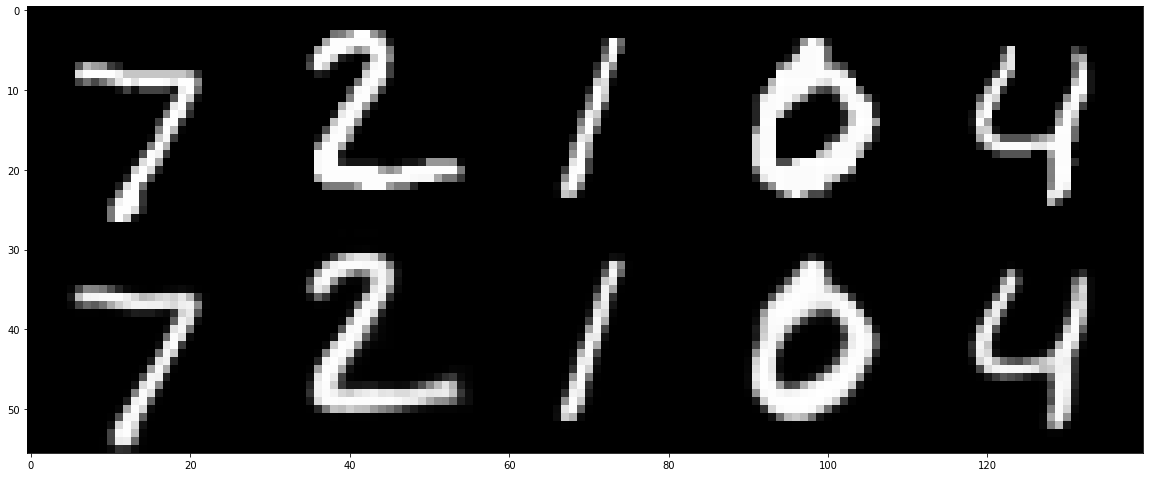

In [10]:
# visualize test data reconstructions
def vis_reconstruction(model):
  # download MNIST test set + build Dataset object
  mnist_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          download=True, 
                                          transform=torchvision.transforms.ToTensor())
  mnist_test_iter = iter(mnist_test)
  model.eval()      # set model in evalidation mode (eg freeze batchnorm params)
  input_imgs, test_reconstructions = [], []
  for _ in range(5):
    input_img = np.asarray(next(mnist_test_iter)[0])
    reconstruction = model.reconstruct(torch.tensor(input_img[None], device=device))
    input_imgs.append(input_img[0])
    test_reconstructions.append(reconstruction[0, 0].data.cpu().numpy())

  fig = plt.figure(figsize = (20, 50))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0), cmap='gray')
  plt.show()

vis_reconstruction(ae_model)

## Sampling from the Auto-Encoder [2pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

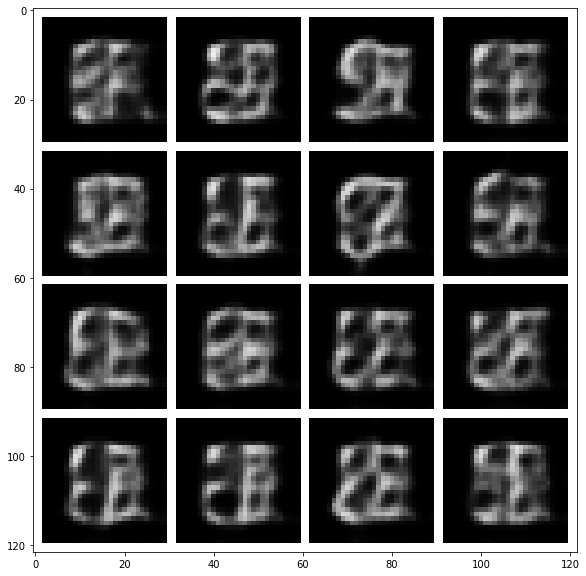

In [11]:
# we will sample N embeddings, then decode and visualize them
def vis_samples(model):
  ####################################### TODO #######################################
  # Sample embeddings from a diagonal unit Gaussian distribution and decode them     #
  # using the model.                                                                 #
  # HINT: The sampled embeddings should have shape [batch_size, nz]. Diagonal unit   #
  #       Gaussians have mean 0 and a covariance matrix with ones on the diagonal    #
  #       and zeros everywhere else.                                                 #
  # HINT: If you are unsure whether you sampled the correct distribution, you can    #
  #       sample a large batch and compute the empirical mean and variance using the #
  #       .mean() and .var() functions.                                              #
  # HINT: You can directly use model.decoder() to decode the samples.                #
  ####################################################################################
  # m = torch.distributions.multivariate_normal.MultivariateNormal(loc, torch.diag(scale))
  # sampled_embeddings = m.sample()
  loc = torch.zeros((batch_size, nz))
  scale = torch.ones(batch_size)
  m = torch.normal(loc, scale).to(device)
  sampled_embeddings = m # sample batch of embedding from prior
  decoded_samples = model.decoder(sampled_embeddings)       # decoder output images for sampled embeddings
  #################################### END TODO ######################################

  fig = plt.figure(figsize = (10, 10))   
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(decoded_samples[:16], nrow=4, pad_value=1.)\
                .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.show()

vis_samples(ae_model)


>**Inline Question: Describe your observations, why do you think they occur? [2pt]** \\
>(please limit your answer to <150 words) \\
>**Answer: An interesting fact is when I increased the number of epoch, the images become more and more similar and hard to recognize or even unrecognizable. When the number of epoch is 10, you can tell nothing from the output image. I guess it's due to the limitation of prior distribution, overfitting and the points distribute are more closed when the reconstruction loss gets smaller, thus generative model will unlikely to generates point close to these points.

# 3. Variational Auto-Encoder (VAE)

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$

Here, $D_{\text{KL}}(q, p)$ denotes the Kullback-Leibler (KL) divergence between the posterior distribution $q(z \vert x)$, i.e. the output of our encoder, and $p(z)$, the prior over the embedding variable $z$, which we can choose freely.

For simplicity, we will again choose a unit Gaussian prior. The left term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} (x - \hat{x})^2 - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$

Here, $\hat{x}$ is the reconstruction output of the decoder. In comparison to the auto-encoder objetive, the VAE adds a regularizing term between the output of the encoder and a chosen prior distribution, effectively forcing the encoder output to not stray too far from the prior during training. As a result the decoder gets trained with samples that look pretty similar to samples from the prior, which will hopefully allow us to generate better images when using the VAE as a generative model and actually feeding it samples from the prior (as we have done for the AE before).

The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.

If you need a refresher on VAEs you can check out this tutorial paper: https://arxiv.org/abs/1606.05908

### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [7pt]

In [12]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5


class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta          # factor trading off between two loss components
    ####################################### TODO #######################################
    # Instantiate Encoder and Decoder.                                                 #
    # HINT: Remember that the encoder is now parametrizing a Gaussian distribution's   #
    #       mean and log_sigma, so the dimensionality of the output embedding needs to #
    #       double.                                                                    #
    ####################################################################################
    self.encoder = Encoder(2 * nz)
    self.decoder = Decoder(nz)
    #################################### END TODO ######################################

  def forward(self, x):
    ####################################### TODO #######################################
    # Implement the forward pass of the VAE.                                           #
    # HINT: Your code should implement the following steps:                            #
    #          1. encode input x, split encoding into mean and log_sigma of Gaussian   #
    #          2. sample z from inferred posterior distribution using                  #
    #             reparametrization trick                                              #
    #          3. decode the sampled z to obtain the reconstructed image               #
    ####################################################################################
    # encode input into posterior distribution q(z | x)
    batch_size = x.shape[0]

    q =  self.encoder(x)      # output of encoder (concatenated mean and log_sigma)
    nz = int(q.shape[1]/2)
    mu_q = q[:, :nz]
    log_sigma_q = q[:, nz:]

    # sample latent variable z with reparametrization
    z =  mu_q + torch.exp(log_sigma_q) * torch.normal(torch.zeros((batch_size, nz)), torch.diag(torch.ones(batch_size))).to(device)     # batch of sampled embeddings
    
    # compute reconstruction
    reconstruction = self.decoder(z)   # decoder reconstruction from embedding
    #################################### END TODO ######################################

    return {'q': q, 
            'rec': reconstruction}

  def loss(self, x, outputs):
    ####################################### TODO #######################################
    # Implement the loss computation of the VAE.                                       #
    # HINT: Your code should implement the following steps:                            #
    #          1. compute the image reconstruction loss, similar to AE we use MSE loss #
    #          2. compute the KL divergence loss between the inferred posterior        #
    #             distribution and a unit Gaussian prior; you can use the provided     #
    #             function above for computing the KL divergence between two Gaussians #
    #             parametrized by mean and log_sigma                                   #
    # HINT: Make sure to compute the KL divergence in the correct order since it is    #
    #       not symmetric, ie. KL(p, q) != KL(q, p)!                                   #
    ####################################################################################
    # compute reconstruction loss
    q, output_img = outputs['q'], outputs['rec']
    nz = int(q.shape[1]/2)
    mu1 = q[:,:nz]
    log_sigma1 = q[:,nz:]

    rec_loss = criterion(x, output_img)

    # compute KL divergence loss
    kl_loss =  kl_divergence(mu1, log_sigma1, torch.zeros(mu1.shape).to(device), torch.diag(torch.ones(mu1.shape[0])).to(device)).mean()     # make sure that this is a scalar, not a vector / array
    #################################### END TODO ######################################
    # return weihgted objective
    return rec_loss + self.beta * kl_loss, \
           {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    ####################################### TODO #######################################
    # This function is used for visualizing reconstructions of our VAE model. To       #
    # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
    # inferred latent and instead directly use the mean of the inferred posterior.     #
    # HINT: encode the input image and then decode the mean of the posterior to obtain #
    #       the reconstruction.                                                        #
    ####################################################################################
    q = self.encoder(x)

    reconstruction = self.decoder(q[:,:int(q.shape[1]/2)])
    #################################### END TODO ######################################
    return reconstruction


## Setting up the VAE Training Loop [4pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


Run Epoch 0
It 0: Total Loss: 2.2790327072143555, 	 Rec Loss: 0.25885632634162903,	 KL Loss: 0.29840123653411865
It 100: Total Loss: 0.1334466189146042, 	 Rec Loss: 0.06356765329837799,	 KL Loss: 0.01032185647636652
It 200: Total Loss: 0.12404054403305054, 	 Rec Loss: 0.05597348138689995,	 KL Loss: 0.010054218582808971
It 300: Total Loss: 0.1120372861623764, 	 Rec Loss: 0.04426790773868561,	 KL Loss: 0.01001024805009365
It 400: Total Loss: 0.1049610823392868, 	 Rec Loss: 0.03721234202384949,	 KL Loss: 0.010007199831306934
It 500: Total Loss: 0.10256433486938477, 	 Rec Loss: 0.03528792783617973,	 KL Loss: 0.00993743073195219
It 600: Total Loss: 0.10618776828050613, 	 Rec Loss: 0.039437174797058105,	 KL Loss: 0.009859763085842133
It 700: Total Loss: 0.10253846645355225, 	 Rec Loss: 0.034156881272792816,	 KL Loss: 0.010100677609443665
It 800: Total Loss: 0.10179531574249268, 	 Rec Loss: 0.034676503390073776,	 KL Loss: 0.009914152324199677
It 900: Total Loss: 0.09559066593647003, 	 Rec Los

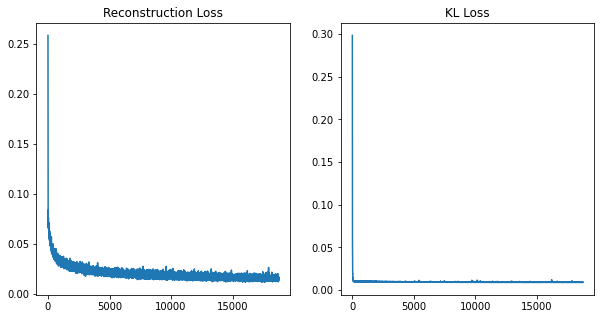

In [35]:
learning_rate = 1e-3
nz = 64

####################################### TODO #######################################
# Tune the beta parameter to obtain good VAE training results. However, for the    #
# initial experiments leave beta = 0 in order to verify our implementation.        #
####################################################################################
epochs = 20         # using 5 epochs is sufficient for the first two experiments
                   # for the experiment where you tune beta, 20 epochs are appropriate
beta = 6.77
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
opt = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)    
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################

  mnist_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size= batch_size, num_workers = nworkers, shuffle= True, drop_last= True) 
  for sample_img, sample_label in mnist_data_loader:
    sample_img, sample_label = sample_img.to(device), sample_label.to(device)
    output = vae_model.forward(sample_img)
    total_loss ,losses = vae_model.loss(sample_img, output)
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    # add VAE training loop commands here
    # ...
    #################################### END TODO ####################################

    rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
print("Done!")

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss)
ax2.title.set_text("KL Loss")
plt.show()

Let's look at some reconstructions and decoded embedding samples!

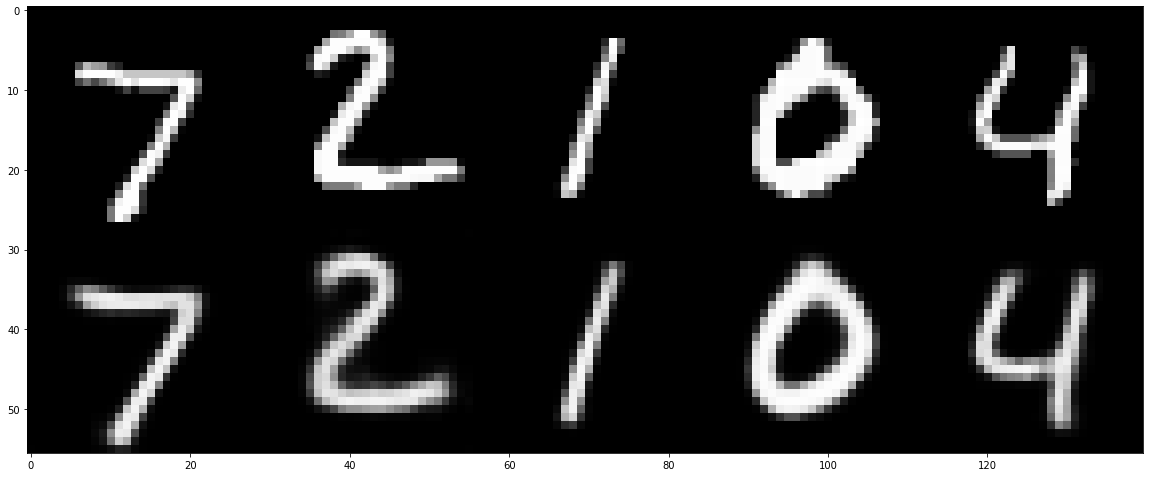

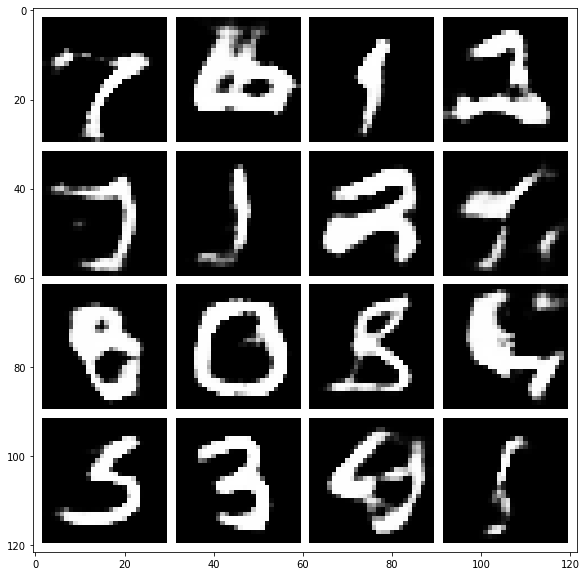

In [37]:
# visualize VAE reconstructions and samples from the generative model
vis_reconstruction(vae_model)
vis_samples(vae_model)

>**Inline Question: What can you observe when setting $\beta = 0$? Explain your observations! [3pt]** \\
>(please limit your answer to <150 words) \\
>**Answer: When $\beta = 0$, though the reconstruction loss gets really small very quickly, KL loss quickly increases. Our reconstruction result is almost perfect because our reconstruction loss really small. But the sampling result is unrecognizable, mainly because KL divergence tells us how well the probability distribution Q approximates the probability distribution P, if we set beta too low, KL is unconstrained, and distribution Q will not approximate P and thus our image cannot be good.


Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient. You can modify the $\beta$ value in the cell above and rerun it (it is okay to overwrite the outputs of the previous experiment, but **make sure to copy the visualizations of training curves, reconstructions and samples for $\beta = 0$ into your solution PDF** before deleting them).

>**Inline Question: What can you observe when setting $\beta = 10$? Explain your observations! [3pt]** \\
>(please limit your answer to <200 words) \\
>**Answer**: Once we make $\beta = 10$, both our reconstruction loss and kl loss decrease very quickly. The difference between reconstruction loss comparing to $\beta = 0$ is our reconstruction loss has a higher variance after reconstruction loss is below 0.05. Our reconstruction image is almost perfect and our sampling result is much better, we can recognize most of them with high probablity. The main reason is our reconstruction and kl loss are both really low.

Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality). 

>**Inline Question: Characterize what properties you would expect for reconstructions (1pt) and samples (2pt) of a well-tuned VAE! [3pt]** \\
>(please limit your answer to <200 words) \\
>**Answer**: I think a "good reasult" should have a sampling result that is easily recognizable with high confidence and without too much blurred and a perfect reconstruction result.

## Tuning the $\beta$-factor [5pt]
Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. 

(logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training). It is again okay to overwrite the results of the previous $\beta=10$ experiment after copying them to the solution PDF. 

**Your final notebook should include the visualizations of your best-tuned VAE.**


# 4. Embedding Space Interpolation [3pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

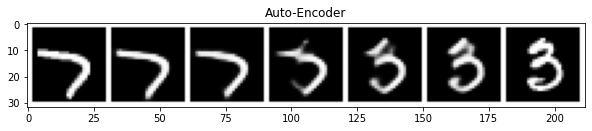

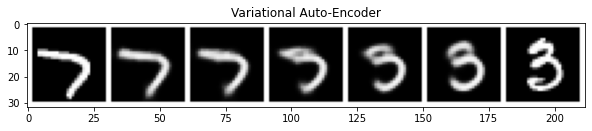

In [48]:
START_LABEL = 7
END_LABEL = 3
nz=64

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  for img_batch, label_batch in mnist_data_loader:
    for img, label in zip(img_batch, label_batch):
      if label == target_label:
        return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()    # put model in eval mode to avoid updating batchnorm

  # encode both images into embeddings (use posterior mean for interpolation)
  z_start = model.encoder(start_img[None])[..., :nz]
  z_end = model.encoder(end_img[None])[..., :nz]

  # compute interpolated latents
  N_INTER_STEPS = 5
  z_inter = [z_start + i/N_INTER_STEPS * (z_end - z_start) for i in range(N_INTER_STEPS)]

  # decode interpolated embeddings (as a single batch)
  img_inter = model.decoder(torch.cat(z_inter))

  # reshape result and display interpolation
  vis_imgs = torch.cat([start_img[None], img_inter, end_img[None]])
  fig = plt.figure(figsize = (10, 10))   
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(vis_imgs, nrow=N_INTER_STEPS+2, pad_value=1.)\
                  .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.title(tag)
  plt.show()


# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)

# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)


Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations!
Focus on**: \\
  1. **How do AE and VAE embedding space interpolations differ?** \\
  2. **How do you expect these differences to affect the usefulness of the learned representation for downstream learning?** \\
(please limit your answer to <300 words)

>**Answer**: 
1. Some digits in AE feel like they are seperated by some cuts and some digits in VAE contains are kind of blurred.
2. Since VAE has KL divergence loss, it has better proximate distribution. That's why digits in AE may seems seperated by some cuts and digits in VAE are more like a real digits. However, VAE will have some higher variance for reconstruction loss, which explains the blurredness in the VAE images. 

# Submission PDF

As in assignment 1, please prepare a separate submission PDF for each problem. For this problem, please include the following plots & answers in a PDF called `problem_1_solution.pdf`:

1. Auto-encoder samples and AE sampling inline question answer.
2. VAE training curves, reconstructions and samples for:
  * $\beta = 0$
  * $\beta = 10$
  * your tuned $\beta$ (also listing the tuned value for $\beta$)
3. Answers to all inline questions in VAE section (ie 3 inline questions).
4. Three representative interpolation comparisons that show AE and VAE embedding interpolation between the same images.
5. Answer to interpolation inline question.

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent (except for those $\beta=0\;/\;10$ plots that we allowed to overwrite).